In [2]:
!pip install pytorch-forecasting

     ------------------------------------ 141.4/141.4 kB 697.5 kB/s eta 0:00:00
     ---------------------------------------- 38.6/38.6 MB 2.2 MB/s eta 0:00:00
     -------------------------------------- 308.2/308.2 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 209.8/209.8 kB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 81.0/81.0 kB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 49.5/49.5 kB 2.5 MB/s eta 0:00:00
     -------------------------------------- 147.1/147.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 95.2/95.2 kB 2.7 MB/s eta 0:00:00
     -------------------------------------- 112.4/112.4 kB 3.3 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11123 sha256=c787166

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.11.4 requires scipy<1.9.0, but you have scipy 1.9.1 which is incompatible.
autogluon-timeseries 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-tabular 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-multimodal 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-core 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.


  Using cached pytorch_forecasting-0.10.3-py3-none-any.whl (141 kB)
  Using cached optuna-2.10.1-py3-none-any.whl (308 kB)
  Using cached scipy-1.9.1-cp38-cp38-win_amd64.whl (38.6 MB)
  Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
  Using cached cliff-4.0.0-py3-none-any.whl (80 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached cmaes-0.8.2-py3-none-any.whl (15 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.11.4 requires scipy<1.9.0, but you have scipy 1.9.1 which is incompatible.
autogluon-timeseries 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-tabular 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-multimodal 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.
autogluon-core 0.5.1 requires scipy<1.8.0,>=1.5.4, but you have scipy 1.9.1 which is incompatible.


  Using cached Mako-1.2.2-py3-none-any.whl (78 kB)
  Using cached importlib_resources-5.9.0-py3-none-any.whl (33 kB)
  Using cached stevedore-4.0.0-py3-none-any.whl (49 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached cmd2-2.4.2-py3-none-any.whl (147 kB)
  Using cached pbr-5.10.0-py2.py3-none-any.whl (112 kB)

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from pytorch_forecasting.metrics import DistributionLoss

In [4]:
from pytorch_forecasting.metrics import MultivariateNormalDistributionLoss

In [5]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error,mean_squared_error
from tensorflow.keras import layers

In [6]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping

In [12]:
DATADIR = ""
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75


# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))     


def datagen(data,key):
    "As a generator to produce samples for Keras model"
    df = data[key]
    index = df.index[df.index < TRAIN_TEST_CUTOFF]
    split = len(index)

    train = df.iloc[:split,:]
    test = df.iloc[split:,:]
    

    return train,test




# Read data into pandas DataFrames
data = {}
for filename in os.listdir(r'E:\Upwork2'):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join('', filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    #index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

In [13]:
train, test = datagen(data,'DJI')

In [14]:
train['Target'] = train['Target'].astype('float')

<ipython-input-14-6fd22bfab0af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Target'] = train['Target'].astype('float')


In [15]:
len(train) == train.index.nunique()

True

In [16]:
train["time_idx"] = np.arange(len(train))

<ipython-input-16-832ec9ece5cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["time_idx"] = np.arange(len(train))


In [17]:
#train_columns = list(train.columns[:-2])
max_encoder_length = 60 # days
max_prediction_length = 100 # 20 days
training_cutoff = train["time_idx"].max() - max_prediction_length

In [18]:
train['Market'] = np.repeat('1',len(train))

<ipython-input-18-ba80443b5d35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Market'] = np.repeat('1',len(train))


In [19]:
train_columns = list(train.columns[:-2])

In [26]:
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Target",
    static_categoricals=['Market'],
    group_ids=['Market'], # list of column names identifying a time series.
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals= ['Target'],
)

In [27]:
validation = TimeSeriesDataSet.from_dataset(training, train, min_prediction_idx=training_cutoff + 1)

In [28]:
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [29]:
pl.seed_everything(42)

Global seed set to 42


42

In [30]:
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30)
)

C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [35]:
trainer = pl.Trainer(
    gradient_clip_val=0.1,
)

C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\loops\utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)

C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at E:\Upwork2\.lr_find_efa2ec9d-65b5-47a6-85be-5305593763a3.ckpt


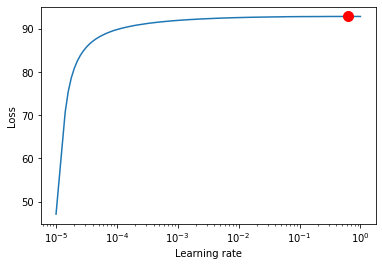

<ipython-input-37-6043caf6ea9d>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [37]:
fig = res.plot(show=True, suggest=True)
fig.show()

In [38]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

In [39]:
trainer = pl.Trainer(
    max_epochs=30,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
net = DeepAR.from_dataset(
    training,
    learning_rate=0.7,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
)

In [41]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: E:\Upwork2\lightning_logs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.5 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [42]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Mohamed\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [44]:
from pytorch_forecasting.metrics import SMAPE

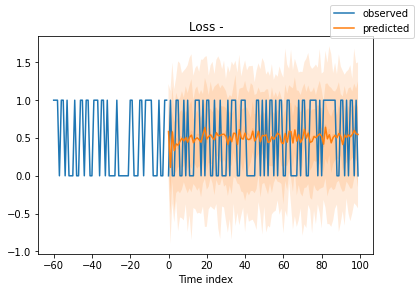

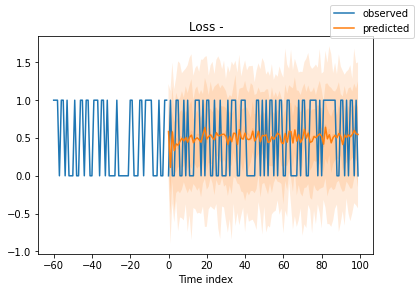

In [47]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

best_model.plot_prediction(
        x,
        raw_predictions,
        idx=0,
        add_loss_to_title=SMAPE()
    )

In [60]:
x

{'encoder_cat': tensor([[[0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0]]]),
 'encoder_cont': tensor([[[ 1.0253],
          [ 1.0253],
          [ 1.0253],
   

In [78]:
raw_predictions[0][0][99]

tensor([ 1.2091,  0.5288,  1.4584,  1.2532,  0.6513,  0.5314,  0.9610,  0.2764,
         0.8803,  0.8686,  0.6640,  0.6848,  0.3270,  0.4480,  0.9474,  1.0132,
         0.8347,  0.8875,  1.0029,  0.0849,  1.0465,  0.3961,  0.4558,  0.3356,
        -0.3178,  0.4648,  0.5658,  0.4751,  0.4488,  0.5634, -0.4297,  1.4985,
         0.7661, -0.1439,  0.2213,  0.2339, -0.1839,  1.4667,  1.1603,  0.1724,
         0.7306,  0.8450,  0.1405,  0.9445,  0.6909,  0.4195,  1.5623, -0.1516,
         0.3598,  1.0078,  0.8659,  0.0278,  0.3344, -1.0225, -0.1282,  0.1761,
         0.5830,  0.7842,  0.1571,  0.1940,  1.3079,  0.5269, -0.3153,  1.4357,
         1.2597,  1.3247,  1.0849,  0.9565,  0.4750, -0.4362,  0.7169, -0.1379,
        -0.0049,  1.1181, -0.3909,  0.8673,  0.4811,  0.8432,  0.8734,  1.1333,
         0.8343,  0.5293,  0.5195,  0.4666,  0.1339, -0.0371,  0.7031, -0.3757,
         0.9665,  0.0649,  0.8454,  1.0152, -0.2321,  0.1206,  1.2477,  0.0592,
        -0.4042,  0.1496,  1.5857,  0.24

In [80]:
x['encoder_target']

tensor([[1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
         1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
         0., 1., 0., 0., 1., 1.]])

In [66]:
from pytorch_forecasting.metrics.point import RMSE

In [81]:
RMSE().loss(raw_predictions[0][0][99],x['encoder_target'])

RuntimeError: The size of tensor a (100) must match the size of tensor b (60) at non-singleton dimension 1